In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/22 - Tensorflow/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/22 - Tensorflow


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Training Loop Basic

# Model Building

In [ ]:
class Model(object):
  def __init__(self):
    # Initialize the weights to `2.0` and the bias to `1.0`
    # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
    self.w = tf.Variable(2.0)
    self.b = tf.Variable(1.0)

  def __call__(self, x):
    return self.w * x + self.b

def loss(predicted_y, target_y):
  '''define loss function'''
  return tf.reduce_mean(tf.square(predicted_y - target_y))

def plot_data(inputs, outputs, predicted_outputs):
  real = plt.scatter(inputs, outputs, c='b', marker='.')
  predicted = plt.scatter(inputs, predicted_outputs, c='r', marker='+')
  plt.legend((real,predicted), ('Real Data', 'Predicted Data'))
  plt.show()

In [ ]:
TRUE_w = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000
xs  = tf.random.normal(shape=[NUM_EXAMPLES])
ys = (TRUE_w * xs) + TRUE_b

Before training the model, visualize the loss value by plotting the model's predictions in red crosses and the training data in blue dots:

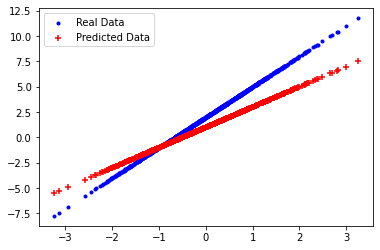

Current loss: 1.931230


In [ ]:
plot_data(xs, ys, model(xs))
print('Current loss: %1.6f' % loss(model(xs), ys).numpy())

## Define a training loop

In [ ]:
# assign_sub combines tf.assign and tf.sub
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dw, db = t.gradient(current_loss, [model.w, model.b])
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)
  return current_loss

Finally, you can iteratively run through the training data and see how `w` and `b` evolve.

In [ ]:
model = Model()

# Collect the history of W-values and b-values to plot later
list_w, list_b = [], []
epochs = 15
losses = []
for epoch in range(epochs):
  list_w.append(model.w.numpy())
  list_b.append(model.b.numpy())
  current_loss = train(model, xs, ys, learning_rate=0.1)
  losses.append(current_loss)
  print('Epoch %2d: w=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, list_w[-1], list_b[-1], current_loss))

Epoch  0: w=2.00 b=1.00, loss=1.93123
Epoch  1: w=2.19 b=1.20, loss=1.25724
Epoch  2: w=2.34 b=1.35, loss=0.81850
Epoch  3: w=2.47 b=1.48, loss=0.53289
Epoch  4: w=2.57 b=1.58, loss=0.34695
Epoch  5: w=2.65 b=1.66, loss=0.22590
Epoch  6: w=2.72 b=1.73, loss=0.14709
Epoch  7: w=2.77 b=1.78, loss=0.09578
Epoch  8: w=2.82 b=1.82, loss=0.06237
Epoch  9: w=2.85 b=1.86, loss=0.04062
Epoch 10: w=2.88 b=1.89, loss=0.02645
Epoch 11: w=2.90 b=1.91, loss=0.01722
Epoch 12: w=2.92 b=1.93, loss=0.01122
Epoch 13: w=2.94 b=1.94, loss=0.00731
Epoch 14: w=2.95 b=1.95, loss=0.00476


In addition to the values for losses, you also plot the progression of trainable variables over epochs.

## Plots for Evaluation
Now you can plot the actual outputs in red and the model's predictions in blue on a set of random test examples.

You can see that the model is able to make predictions on the test set fairly accurately.

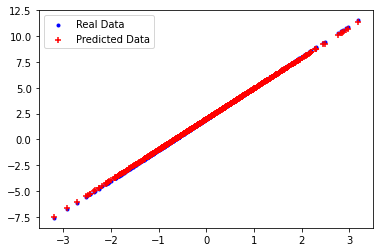

In [ ]:
test_inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
test_outputs = test_inputs * TRUE_w + TRUE_b

predicted_test_outputs = model(test_inputs)
plot_data(test_inputs, test_outputs, predicted_test_outputs)

Visualize the cost function against the values of each of the trainable weights the model approximated to over time.

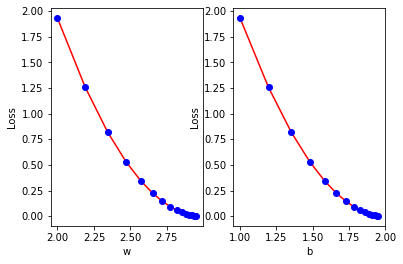

In [ ]:
def plot_loss_for_weights(weights_list, losses):
  for idx, weights in enumerate(weights_list):
    plt.subplot(120 + idx + 1)
    plt.plot(weights['values'], losses, 'r')
    plt.plot(weights['values'], losses, 'bo')
    plt.xlabel(weights['name'])
    plt.ylabel('Loss')

weights_list = [{ 'name' : "w", 'values' : list_w}, {'name' : "b", 'values' : list_b}]
plot_loss_for_weights(weights_list, losses)

# Training Loop Advance


## Data Preparation

In [ ]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [ ]:
train_data, info = tfds.load("fashion_mnist", split="train", with_info=True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split="test", data_dir='./data/', download=True)
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test =  test_data.batch(batch_size=batch_size)

## Model Building

In [ ]:
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

In [ ]:
# optimizer and metric
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Building Training Loop

In [ ]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  return logits, loss_value

In [ ]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
      losses.append(loss_value)
      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

## Model Training

In [ ]:
model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

Start of epoch 0


Training loss for step 937: 0.5193: 100%|█████████▉| 937/938 


 Epoch 0: Train loss: 0.5339  Validation Loss: 0.4346, Train Accuracy: 0.8098, Validation Accuracy 0.8422
Start of epoch 1


Training loss for step 937: 0.2400: 100%|█████████▉| 937/938 


 Epoch 1: Train loss: 0.3800  Validation Loss: 0.3902, Train Accuracy: 0.8613, Validation Accuracy 0.8612
Start of epoch 2


Training loss for step 937: 0.2348: 100%|█████████▉| 937/938 


 Epoch 2: Train loss: 0.3437  Validation Loss: 0.3931, Train Accuracy: 0.8759, Validation Accuracy 0.8610
Start of epoch 3


Training loss for step 937: 0.3065: 100%|█████████▉| 937/938 


 Epoch 3: Train loss: 0.3227  Validation Loss: 0.3764, Train Accuracy: 0.8822, Validation Accuracy 0.8670
Start of epoch 4


Training loss for step 937: 0.2183: 100%|█████████▉| 937/938 


 Epoch 4: Train loss: 0.3063  Validation Loss: 0.3708, Train Accuracy: 0.8881, Validation Accuracy 0.8702
Start of epoch 5


Training loss for step 937: 0.1291: 100%|█████████▉| 937/938 


 Epoch 5: Train loss: 0.2920  Validation Loss: 0.3554, Train Accuracy: 0.8927, Validation Accuracy 0.8726
Start of epoch 6


Training loss for step 937: 0.3134: 100%|█████████▉| 937/938 


 Epoch 6: Train loss: 0.2807  Validation Loss: 0.3635, Train Accuracy: 0.8966, Validation Accuracy 0.8713
Start of epoch 7


Training loss for step 937: 0.5018: 100%|█████████▉| 937/938 


 Epoch 7: Train loss: 0.2718  Validation Loss: 0.3519, Train Accuracy: 0.8990, Validation Accuracy 0.8786
Start of epoch 8


Training loss for step 937: 0.1940: 100%|█████████▉| 937/938 


 Epoch 8: Train loss: 0.2605  Validation Loss: 0.3665, Train Accuracy: 0.9031, Validation Accuracy 0.8715
Start of epoch 9


Training loss for step 937: 0.2144: 100%|█████████▉| 937/938 


 Epoch 9: Train loss: 0.2530  Validation Loss: 0.3478, Train Accuracy: 0.9047, Validation Accuracy 0.8826


## Evaluation

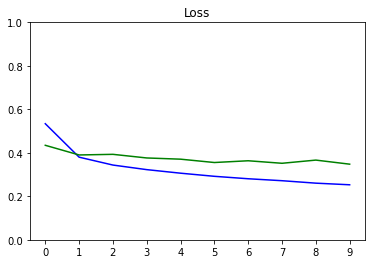

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):
  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 
  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

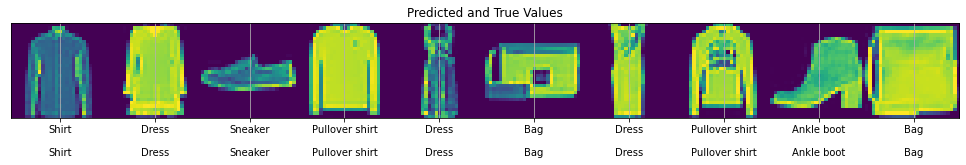

In [ ]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)

# Implementation

## Data Preparation

In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [ ]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data_file = tf.keras.utils.get_file("breast_cancer.csv", DATASET_URL)
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)

df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)
df['class'] = np.where(df['class'] == 2, 0, 1)
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [ ]:
train, test = train_test_split(df, test_size = 0.2)

train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()

train_Y = train.pop("class")
test_Y = test.pop("class")

norm_train_X = norm(train)
norm_test_X = norm(test)

train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)
test_dataset =  test_dataset.batch(batch_size=batch_size)

In [ ]:
a = enumerate(train_dataset)
print(len(list(a)))

18


## Model Building

In [ ]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

## Evaluation

In [ ]:
# untrained model
outputs = model(norm_test_X.values)
loss_value = loss_object(y_true=test_Y.values.reshape(-1 ,1), y_pred=outputs)
print("Loss before training %.4f" % loss_value.numpy())

Loss before training 0.7806


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

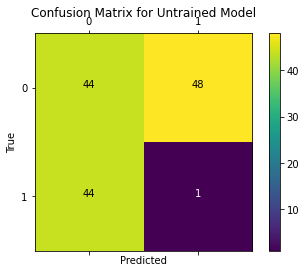

In [ ]:
plot_confusion_matrix(test_Y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')

In [ ]:
# metrics
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        '''initializes attributes of the class'''
        
        # call the parent class init
        super(F1Score, self).__init__(name=name, **kwargs)

        # Initialize Required variables
        # true positives
        self.tp = tf.Variable(0, dtype = 'int32')
        # false positives
        self.fp = tf.Variable(0, dtype = 'int32')
        # true negatives
        self.tn = tf.Variable(0, dtype = 'int32')
        # false negatives
        self.fn = tf.Variable(0, dtype = 'int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates statistics for the metric
        
        Args:
            y_true: target values from the test data
            y_pred: predicted values by the model
        '''

        # Calulcate confusion matrix.
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
        
        # Update values of true positives, true negatives, false positives and false negatives from confusion matrix.
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])

    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)
      
        # Calculate recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)

        # Return F1 Score
        f1_score = 2 * (precision * recall) / (precision + recall)
        
        return f1_score

    def reset_states(self):
        '''Resets all of the metric state variables.'''
        
        # The state of the metric will be reset at the start of each epoch.
        self.tp.assign(0)
        self.tn.assign(0) 
        self.fp.assign(0)
        self.fn.assign(0)

In [ ]:
train_f1score_metric = F1Score()
val_f1score_metric = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

## Model Training

In [ ]:
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    applies the gradients to the trainable model weights
    
    Args:
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        x: input data to the model
        y: target values for each input
    '''
    
    with tf.GradientTape() as tape:
        logits = model(x) 
        loss_value = loss_object(y_true = y, y_pred = logits)
  
    gradients = tape.gradient(loss_value , model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights)) 
  
    return logits, loss_value

def train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, train_acc_metric, train_f1score_metric, verbose=True):
    '''
    Computes the loss then updates the weights and metrics for one epoch.
    
    Args:
        train_dataset: the training dataset
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        train_acc_metric: calculates how often predictions match labels
        train_f1score_metric: custom metric we defined earlier
    '''
    losses = []

    #Iterate through all batches of training data
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        #Calculate loss and update trainable variables using optimizer
        logits, loss_value = apply_gradient(optimizer, loss_object, model, x_batch_train, y_batch_train)
        losses.append(loss_value)

        #Round off logits to nearest integer and cast to integer for calulating metrics
        logits = tf.round(logits)
        logits = tf.cast(logits, 'int64')

        #Update the training metrics
        train_acc_metric.update_state(y_batch_train, logits)
        train_f1score_metric.update_state(y_batch_train, logits)

        #Update progress
        if verbose:
            print("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
    
    return losses

def perform_validation():
    losses = []

    #Iterate through all batches of validation data.
    for x_val, y_val in test_dataset:

        #Calculate validation loss for current batch.
        val_logits = model(x_val) 
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)

        #Round off and cast outputs to either  or 1
        val_logits = tf.cast(tf.round(model(x_val)), 'int64')

        #Update validation metrics
        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)
        
    return losses

In [ ]:
# Iterate over epochs.
epochs = 5
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    # Perform Training over all batches of train data
    losses_train = train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, train_acc_metric, train_f1score_metric)

    # Get results from training metrics
    train_acc = train_acc_metric.result()
    train_f1score = train_f1score_metric.result()

    #Perform validation on all batches of test data
    losses_val = perform_validation()

    # Get results from validation metrics
    val_acc = val_acc_metric.result()
    val_f1score = val_f1score_metric.result()

    #Calculate training and validation losses for current epoch
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epcoh %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc), train_f1score, val_f1score))

    #Reset states of all metrics
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    val_f1score_metric.reset_states()
    train_f1score_metric.reset_states()

Start of epoch 0
Training loss for step 0: 0.8185
Training loss for step 1: 0.5900
Training loss for step 2: 0.5438
Training loss for step 3: 0.4394
Training loss for step 4: 0.3492
Training loss for step 5: 0.3676
Training loss for step 6: 0.3241
Training loss for step 7: 0.2429
Training loss for step 8: 0.2175
Training loss for step 9: 0.2524
Training loss for step 10: 0.2588
Training loss for step 11: 0.2110
Training loss for step 12: 0.1851
Training loss for step 13: 0.2011
Training loss for step 14: 0.2142
Training loss for step 15: 0.1460
Training loss for step 16: 0.1170
Training loss for step 17: 1.0218

 Epcoh 0: Train loss: 0.3611  Validation Loss: 0.1461, Train Accuracy: 0.8819, Validation Accuracy 0.9875, Train F1 Score: 0.8602, Validation F1 Score: 0.9778
Start of epoch 1
Training loss for step 0: 0.1937
Training loss for step 1: 0.1765
Training loss for step 2: 0.1069
Training loss for step 3: 0.1686
Training loss for step 4: 0.1897
Training loss for step 5: 0.1768
Traini

## Evaluation

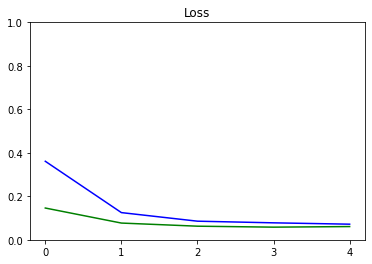

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

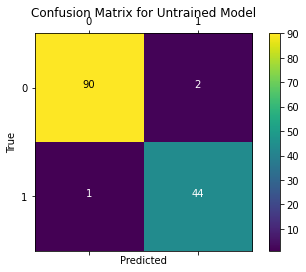

In [ ]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_Y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')